In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

2024-08-02 08:11:22.928607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.15.0
Keras version: 2.15.0


In [2]:
class RestrictedCubicSplineWith3KnotPositions(tf.keras.layers.Layer):
    def __init__(self, knots, **kwargs):
        super(RestrictedCubicSplineWith3KnotPositions, self).__init__(**kwargs)
        self.knots = tf.constant(knots, dtype=tf.float32)        

    def call(self, inputs):
        x = inputs
        knots = self.knots
        
        k0 = knots[0]
        k1 = knots[1]
        k2 = knots[2]
        c = (k2 - k0) * (k2 - k0)
        
        # Calculate basis functions
        y = ((tf.maximum(x - k0, 0)**3 - tf.maximum(x - k1, 0)**3 * (k2 - k0)/(k2 - k1) + tf.maximum(x - k2, 0)**3 * (k1 - k0)/(k2 - k1)) / c)
        basis = [x, y]
        
        return tf.stack(basis, axis=-1)

In [3]:
# Model parameters

age_knots = [2, 10, 16] # The position of the knots for age 
ct_knots = [18.6, 25.2, 34.5] # The position of the knots for CT 
bias = np.array([6.5164]).reshape(1, ) # The intercept
weights = np.array([[-0.3806], [0.3034], [-0.2139], [0.1545], [0.3245], [0.2672], [0.3624], [0.427]]) # The features' coefficients
features = ['PatientAge', 'CT', 'AnyBleeding', 'Diarrhoea', 'Breathlessness', 'SwallowingProblems']
out_var = 'S7.FinalStatus'

var_dict = {
  'Death':out_var,
  'PatientAge':'AD.Age',
  'CT':'Lab.CtNP.D1',
  'AnyBleeding':'S2.Bleeding',
  'Diarrhoea':'S2.Diarrhea',
  'Breathlessness':'S2.DifficultyBreathing', 
  'SwallowingProblems':'S2.DifficultySwallowing'
}

In [4]:
# Define inputs
input_rcs_age = tf.keras.Input(shape=(1,), name="input_rcs_age")
input_rcs_ct = tf.keras.Input(shape=(1,), name="input_rcs_ct")
input_linear_feats = tf.keras.Input(shape=(4,), name="input_linear_feats")

# Apply RCS transformation
input_rcs_age_transformed = RestrictedCubicSplineWith3KnotPositions(age_knots)(input_rcs_age)
input_rcs_ct_transformed = RestrictedCubicSplineWith3KnotPositions(ct_knots)(input_rcs_ct)

# Reshape RCS-transformed features to match the shape of untouched features
input_rcs_age_transformed = tf.keras.layers.Reshape((-1,))(input_rcs_age_transformed)
input_rcs_ct_transformed = tf.keras.layers.Reshape((-1,))(input_rcs_ct_transformed)

# Combine RCS-transformed features with linear features
combined_features = tf.keras.layers.Concatenate()([input_rcs_age_transformed, input_rcs_ct_transformed, input_linear_feats])

In [5]:
# Define the logistic regression model
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="logreg")(combined_features)
model = tf.keras.Model(inputs=[input_rcs_age, input_rcs_ct, input_linear_feats], outputs=outputs, name="ebola-pediatric-prognosis")
model.compile(loss = "binary_crossentropy")
model.summary()

Model: "ebola-pediatric-prognosis"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_rcs_age (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 input_rcs_ct (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 restricted_cubic_spline_wi  (None, 1, 2)                 0         ['input_rcs_age[0][0]']       
 th3_knot_positions (Restri                                                                       
 ctedCubicSplineWith3KnotPo                                                                       
 sitions)                                                                 

In [6]:
model.set_weights([weights, bias])
model.get_weights()

[array([[-0.3806],
        [ 0.3034],
        [-0.2139],
        [ 0.1545],
        [ 0.3245],
        [ 0.2672],
        [ 0.3624],
        [ 0.427 ]], dtype=float32),
 array([6.5164], dtype=float32)]

In [7]:
# Loading the data
drc_data_file = 'ebola-pediatric-prognosis/data.csv'
drc_data = pd.read_csv(drc_data_file, na_values="\\N")

columns = [out_var] + [var_dict[var] for var in features]

test_data = drc_data[columns]
complete_data = test_data.dropna()
complete_data

,S7.FinalStatus,AD.Age,Lab.CtNP.D1,S2.Bleeding,S2.Diarrhea,S2.DifficultyBreathing,S2.DifficultySwallowing
0,0.0,13.000,27.2,0,1,0,0
1,1.0,14.000,18.5,1,1,1,1
2,1.0,5.000,18.1,1,1,1,0
3,0.0,0.250,18.7,0,0,0,0
4,0.0,8.000,25.4,0,1,1,1
...,...,...,...,...,...,...,...
67,0.0,7.000,27.3,0,0,0,0
69,1.0,17.000,20.5,0,0,0,0
70,0.0,0.167,22.1,0,0,0,0
71,0.0,1.000,18.5,0,0,0,0


In [8]:
all_feat_values = complete_data[complete_data.columns[1:]].values
age_values = all_feat_values[:,0]
ct_values = all_feat_values[:,1]
symp_values = all_feat_values[:,2:]

out_values = [int(v) for v in complete_data[complete_data.columns[0]].values]

In [9]:
# Make predictions
pred_probs = model.predict([age_values, ct_values, symp_values])
pred_values = (pred_probs > 0.5).astype("int32")

3/3 [==============================] - 0s 1ms/step


In [13]:
print(confusion_matrix(out_values, pred_values))
print(classification_report(out_values, pred_values))
print(f'Accuracy Score: {accuracy_score(out_values, pred_values)}')

roc_auc = roc_auc_score(out_values, pred_probs)
print(f'ROC-AUC Score: {roc_auc}')

[[19 17]
 [ 3 28]]
              precision    recall  f1-score   support

           0       0.86      0.53      0.66        36
           1       0.62      0.90      0.74        31

    accuracy                           0.70        67
   macro avg       0.74      0.72      0.70        67
weighted avg       0.75      0.70      0.69        67

Accuracy Score: 0.7014925373134329
ROC-AUC Score: 0.7589605734767025


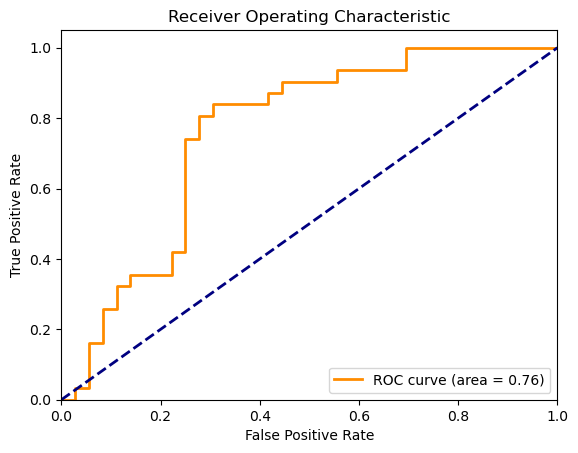

In [14]:
fpr, tpr, _ = roc_curve(out_values, pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Convert and save the model.
# DON'T RUN, IT CRASHES THE NOTEBOOK IF USING KERAS 3:
# https://github.com/tensorflow/tensorflow/issues/64273

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.allow_custom_ops = False  # Ensuring only supported ops are allowed; set to True if custom ops are necessary.
tflite_model = converter.convert()

with open('ebola-pediatric-prognosis/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/tmpf2gr6hns/assets


INFO:tensorflow:Assets written to: /var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/tmpf2gr6hns/assets
2024-08-02 08:13:44.447410: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-08-02 08:13:44.447423: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-08-02 08:13:44.447561: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/tmpf2gr6hns
2024-08-02 08:13:44.448655: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-08-02 08:13:44.448663: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/tmpf2gr6hns
2024-08-02 08:13:44.451142: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-08-02 08:13:44.466330: I tensorflow/cc/saved_model/loader.cc:217] Running initialization